# LeNet CNN model to train on mnist


In [1]:
#imports

import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Torch CUDA version:", torch.version.cuda)
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F
import torch.nn as nn

cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Torch version: 2.5.1+cu121
CUDA available: True
Torch CUDA version: 12.1
CUDA device: NVIDIA GeForce RTX 4070


MNIST Data

In [2]:
transform = list()
transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
transform = T.Compose(transform)                          # Composes the above transformations into one.

full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

The Model

In [3]:
#LeNet

class LeNet(nn.Module):
    def __init__(self, dataset='mnist'):
        super(LeNet, self).__init__()

        self.dataset = dataset.lower()
        self.in_channels = 1 if self.dataset == 'mnist' else 3
        self.input_size = (28, 28) if self.dataset == 'mnist' else (32, 32)

        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=6, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # We'll initialize fc1 dynamically
        self.fc1 = None
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self._init_fc1()

    def _init_fc1(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.in_channels, *self.input_size)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            num_features = x.view(1, -1).shape[1]
            self.fc1 = nn.Linear(num_features, 120)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # flatten the feature maps into a long vector
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) # or sigmoid
        x = F.log_softmax(self.fc3(x)) # or softmax

        return x

    def getCostFunction(self):
        cost_function = F.nll_loss
        return cost_function

    def getOptimizer(self, lr, wd, momentum):
        return torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)

    def testNet(self, data_loader, cost_function, device='cuda:0'):
        samples = 0.
        cumulative_loss = 0.
        cumulative_accuracy = 0.

        self.eval() # Strictly needed if network contains layers which has different behaviours between train and test

        with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(data_loader):
            # Load data into GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = self(inputs)

            # Apply the loss
            loss = cost_function(outputs, targets)

            # Better print something
            samples+=inputs.shape[0]
            cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
            _, predicted = outputs.max(1)
            cumulative_accuracy += predicted.eq(targets).sum().item()

        return cumulative_loss/samples, cumulative_accuracy/samples*100


    def trainNet(self, data_loader,optimizer,cost_function, device='cuda:0'):
        samples = 0.
        cumulative_loss = 0.
        cumulative_accuracy = 0.

        cumulative_patience = []


        self.train() # Strictly needed if network contains layers which has different behaviours between train and test
        for batch_idx, (inputs, targets) in enumerate(data_loader):
          # Load data into GPU
          inputs = inputs.to(device)
          targets = targets.to(device)

          # Forward pass
          outputs = self(inputs)

          # Apply the loss
          loss = cost_function(outputs,targets)

          # Reset the optimizer

          # Backward pass
          loss.backward()

          # Update parameters
          optimizer.step()

          optimizer.zero_grad()

          # Better print something, no?
          samples+=inputs.shape[0]
          cumulative_loss += loss.item()
          _, predicted = outputs.max(1)
          cumulative_accuracy += predicted.eq(targets).sum().item()

        return cumulative_loss/samples, cumulative_accuracy/samples*100
    
    def getData(self, batch_size, test_batch_size, train_data, test_data):
        num_samples = len(train_data)

        training_samples = int(num_samples*0.9+1)
        validation_samples = num_samples - training_samples

        training_data, validation_data = torch.utils.data.random_split(train_data, [training_samples, validation_samples])

        # Initialize dataloaders
        train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

In [4]:
# Find which character is often confused with which

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
def compute_confusion_matrix(model, test_loader, device='cuda:0', dataset='mnist'):
    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    if dataset == 'cifar10':
        labels = cifar10_labels
    else:
        labels = list(range(10))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    return cm

In [6]:
def plot_confusion_matrix(cm, dataset='mnist'):
    plt.figure(figsize=(10, 8))
    if dataset == 'cifar10':
        labels = cifar10_labels
    else:
        labels = list(range(10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
import random

def plot_random_images(model, test_loader, num_images=6, dataset='mnist'):  
    # Switch model to eval mode and move to CPU
    model.eval()
    model = model.to('cpu')

    # Flatten the test loader into a list of (image, label) pairs
    all_images = []
    for inputs, labels in test_loader:
        for i in range(len(inputs)):
            all_images.append((inputs[i], labels[i]))
    
    # Randomly select num_images samples
    selected = random.sample(all_images, num_images)

    # Plot them
    plt.figure(figsize=(15, 3))
    for i, (img, label) in enumerate(selected):
        img_input = img.unsqueeze(0)  # Add batch dimension
        output = model(img_input)
        pred = output.argmax(dim=1).item()

        plt.subplot(1, num_images, i + 1)
        if dataset == 'cifar10':
            plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize and permute for CIFAR-10
            plt.title(f'Pred: {cifar10_labels[pred]}, True: {cifar10_labels[label.item()]}')
        else:
            plt.imshow(img.squeeze().numpy(), cmap='gray')
            plt.title(f'Pred: {pred}, True: {label.item()}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Main Code

In [ ]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         test_batch_size=265,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=100,
         early_stopping=False,
         early_stopping_patience=5,
         early_stopping_threshold=0.001,
         full_training_data=full_training_data,
         test_data=test_data,
         dataset='mnist'):
  
  net = LeNet(dataset=dataset).to(device)

  train_loader, val_loader, test_loader = net.getData(batch_size, test_batch_size, full_training_data, test_data)  

  optimizer = net.getOptimizer(learning_rate, weight_decay, momentum)

  cost_function = net.getCostFunction()

  print('Before training:')
  train_loss, train_accuracy = net.testNet(train_loader, cost_function)
  val_loss, val_accuracy = net.testNet(val_loader, cost_function)
  test_loss, test_accuracy = net.testNet(test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
  acc_patience = []
  for e in range(epochs):
    train_loss, train_accuracy = net.trainNet(train_loader, optimizer, cost_function, device=device)
    val_loss, val_accuracy = net.testNet(val_loader, cost_function)

    scheduler.step()
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    if early_stopping:
      acc_patience.append(val_loss)
      if len(acc_patience) > early_stopping_patience:
        if np.abs(acc_patience[-1] - acc_patience[-early_stopping_patience]) < early_stopping_threshold:
          print('!!!!Early stopping at epoch:', e+1, '!!!!')
          break
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = net.testNet(train_loader, cost_function)
  val_loss, val_accuracy = net.testNet(val_loader, cost_function)
  test_loss, test_accuracy = net.testNet(test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  print('Confusion matrix:')
  cm = compute_confusion_matrix(net, test_loader, device=device, dataset=dataset)
  plot_confusion_matrix(cm, dataset=dataset)
  print('-----------------------------------------------------')

  print('Random images:')
  plot_random_images(net, test_loader, num_images=6, dataset=dataset)
  print('-----------------------------------------------------')

  return net

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

Before training:


C:\Users\Elmrys\AppData\Local\Temp\ipykernel_21600\223054081.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x)) # or softmax


	 Training loss 0.01799, Training accuracy 10.22
	 Validation loss 0.00883, Validation accuracy 10.19
	 Test loss 0.00875, Test accuracy 10.10
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00139, Training accuracy 94.31
	 Validation loss 0.00028, Validation accuracy 97.87
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00059, Training accuracy 97.84
	 Validation loss 0.00026, Validation accuracy 98.40
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00046, Training accuracy 98.39
	 Validation loss 0.00027, Validation accuracy 98.35
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00045, Training accuracy 98.39
	 Validation loss 0.00026, Validation accuracy 98.27
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00041, Training accuracy 98.62
	 Validation loss 0.00029, Validation accuracy 98.23
--------------------------------

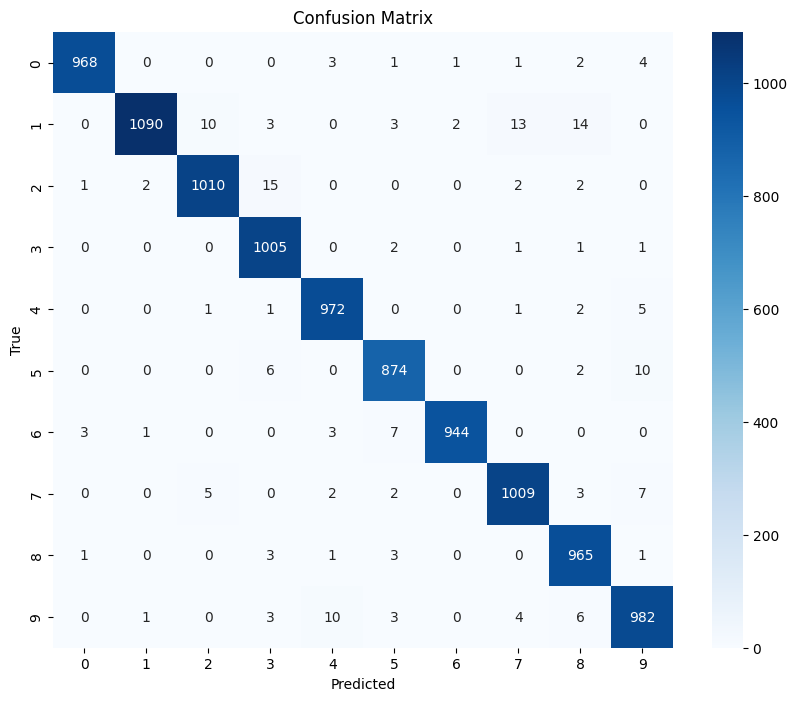

-----------------------------------------------------
Random images:


C:\Users\Elmrys\AppData\Local\Temp\ipykernel_21600\223054081.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x)) # or softmax


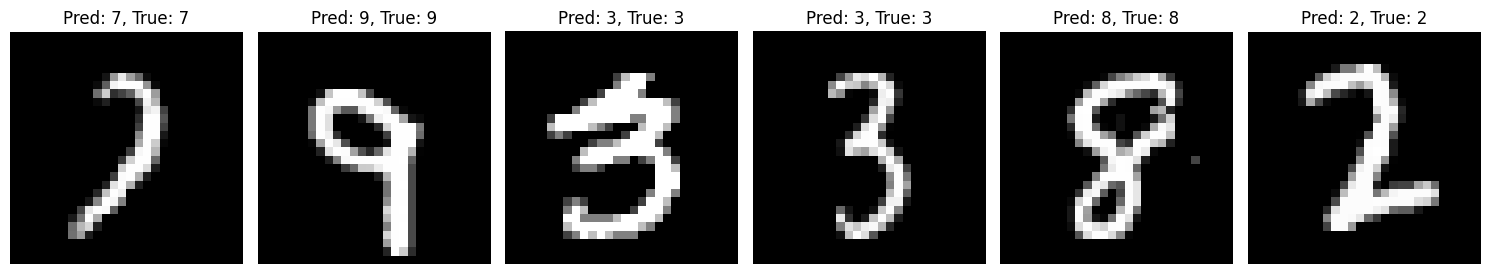

-----------------------------------------------------


In [ ]:
myModel = main(batch_size=128,
        test_batch_size=265,
         device='cuda:0',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=100,
         early_stopping=True,
         early_stopping_patience=5,
         early_stopping_threshold=0.00005,
         dataset='mnist')

In [ ]:
# Save my model to ./Models/mnist_leNet

torch.save(myModel.state_dict(), './Models/mnist_leNet.pth')

# Save the model architecture to a file
torch.save(myModel, './Models/mnist_leNet_model.pth')

In [11]:
# same thing for cifar10

#imprt transforms
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_training_data_cifar = torchvision.datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
test_data_cifar = torchvision.datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


Before training:


C:\Users\Elmrys\AppData\Local\Temp\ipykernel_21600\223054081.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x)) # or softmax


	 Training loss 0.01803, Training accuracy 9.66
	 Validation loss 0.00875, Validation accuracy 10.26
	 Test loss 0.00876, Test accuracy 9.28
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01580, Training accuracy 22.66
	 Validation loss 0.00734, Validation accuracy 26.91
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01449, Training accuracy 29.69
	 Validation loss 0.00703, Validation accuracy 29.99
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01424, Training accuracy 30.94
	 Validation loss 0.00699, Validation accuracy 30.11
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01408, Training accuracy 31.34
	 Validation loss 0.00687, Validation accuracy 30.05
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01394, Training accuracy 32.58
	 Validation loss 0.00687, Validation accuracy 31.81
----------------------------------

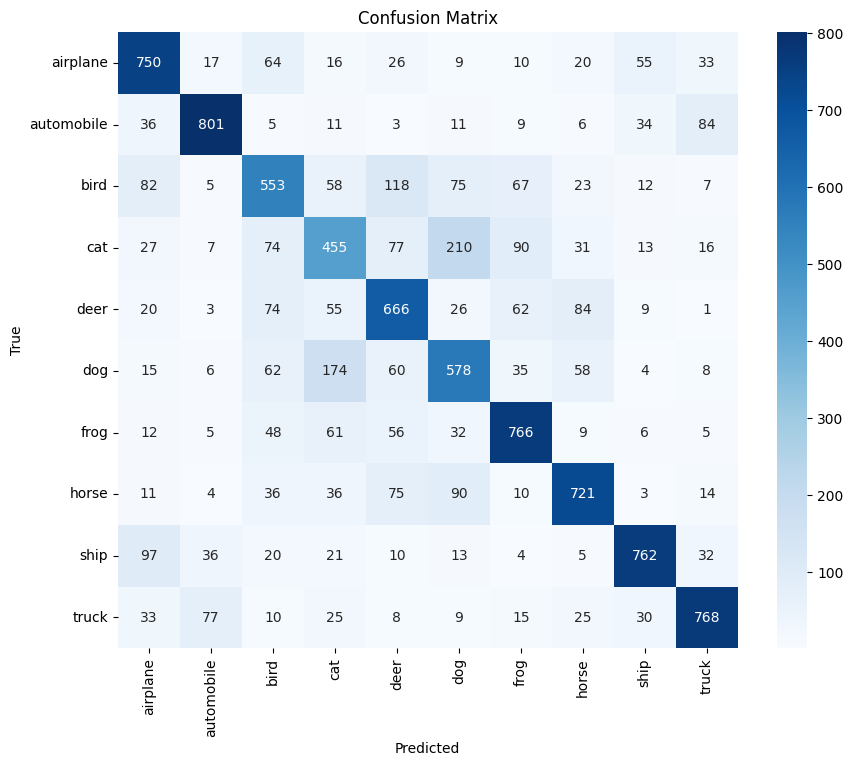

-----------------------------------------------------
Random images:


C:\Users\Elmrys\AppData\Local\Temp\ipykernel_21600\223054081.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x)) # or softmax


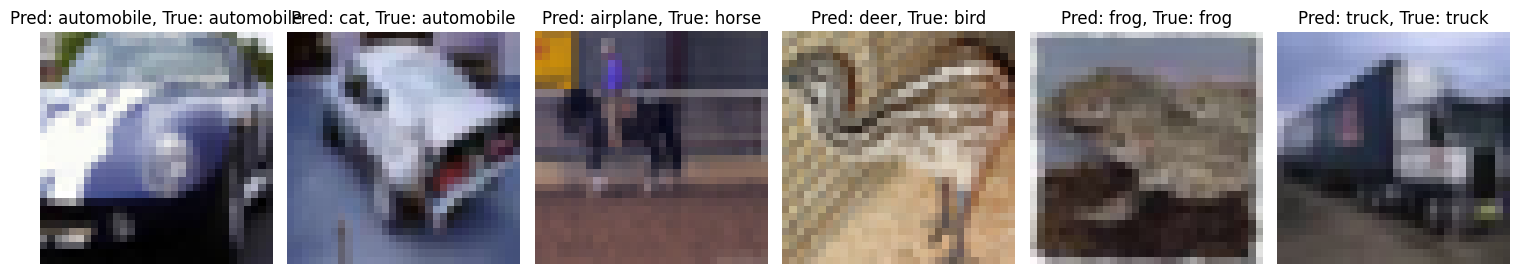

-----------------------------------------------------


In [ ]:
main(batch_size=128,
        test_batch_size=265,
         device='cuda:0',
         learning_rate=0.02,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=200,
         early_stopping=True,
         early_stopping_patience=20,
         early_stopping_threshold=0.00001,
         full_training_data=full_training_data_cifar,
         test_data=test_data_cifar,
         dataset='cifar10')